## PixelCNN

The PixelCNN architecture is a generative model that modifies the standard convolutional neural network (CNN) by introducing an autoregressive component. In PixelCNN, the model predicts each pixel value one at a time, with each prediction being conditioned on the previously predicted pixels. This allows the model to capture complex spatial dependencies, both local and global, within an image.

Because of its autoregressive nature, PixelCNN is inherently sequential, which means that the generation process can be slower compared to traditional CNNs. This sequential approach introduces additional computational demands, making training and inference more time-consuming. However, the architecture excels in producing high-quality images by learning dependencies between pixels.

PixelCNN relies on a combination of masked convolutions and residual blocks. Masked convolutions ensure that the model only has access to pixels that have already been generated, preserving the autoregressive property. Residual blocks help facilitate the training of deeper networks, allowing the model to capture more detailed pixel relationships. These architectural components, while effective, contribute to the overall complexity of the model and can result in longer training times.

**Challenges:**
- Training time: Due to its autoregressive nature, training PixelCNN can take longer as the model needs to learn complex pixel dependencies over many epochs.
- Computational demands: The architecture’s depth and sequential structure require significant compute resources, especially for larger datasets or high-resolution images.
- Instability risks: Larger architectures increase the risk of training instability. Proper hyperparameter tuning (such as learning rate, regularization, and batch size) is crucial to avoid issues like vanishing gradients or overfitting during training.

Despite these challenges, PixelCNN is a powerful model for generating high-quality images, particularly when the goal is to model complex pixel dependencies in a structured and interpretable way.

Code is Adapted and updated from the book [Generative Deep Learning: Teaching Machines to Paint, Write, Compose, and Play](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=pd_sbs_d_sccl_2_1/130-9125606-0943241?pd_rd_w=FhXH7&content-id=amzn1.sym.156274ff-6322-443d-8bbf-ab3ed87e382f&pf_rd_p=156274ff-6322-443d-8bbf-ab3ed87e382f&pf_rd_r=ZD77MMX08RJGV0GG0MMC&pd_rd_wg=tEpZf&pd_rd_r=93f3b12b-d7f8-488a-a6e3-05de7a8f06dc&pd_rd_i=1098134184&psc=1)

## Defining Functions and Classes

In [2]:
# Checks for changes in all imported modules and reloads them
# if they have been modified
%load_ext autoreload
%autoreload 2

# Package imports
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
import matplotlib.pyplot as plt
import matplotlib

In [3]:
# Create batch sampling function
def sample_batch(dataset):
    """
    Samples a single batch from the dataset and returns it as a NumPy array.
    """
    try:
        # Take a single batch from the dataset
        batch = dataset.take(1).get_single_element()

        # If the batch is a tuple (e.g., data and labels), extract the data part
        if isinstance(batch, tuple):
            batch = batch[0]

        # Convert the batch to a NumPy array
        return batch.numpy()

    # Catch any exceptions that may occur
    except Exception as e:
        print(f"Error in loading batch: {e}")
        return None


# Function to display images
def display(
    images, n=10, size=None, cmap="gray_r", as_type="float32",
    save_to=None, show_axes=False
):
    """
    Displays n random images from the provided array and
    optionally saves the plot.
    """
    # Ensure image values are between 0 and 1, for display consistency
    if images.max() > 1.0 or images.min() < 0.0:
        images = np.clip(images, 0, 1)

    # If no size is provided, dynamically adjust the size based
    # on the number of images
    if size is None:
        size = (n * 2, 3)  # Set figure width relative to number of images

    # Create a new figure for displaying the images
    plt.figure(figsize=size)

    # Loop through the first 'n' images (or fewer if the array is smaller)
    for i in range(min(n, len(images))):
        _ = plt.subplot(1, min(n, len(images)), i + 1)  # Create a subplot for
                                                        # each image

        # Display each image after converting it to the specified type
        plt.imshow(images[i].astype(as_type), cmap=cmap)

        # Optionally hide axis labels if 'show_axes' is False
        if not show_axes:
            plt.axis("off")

    # Save the plot to a file if 'save_to' is provided
    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")  # Notify the user that the
                                        # file has been saved

    # Show the plot
    plt.show()

In [6]:
# Subclassing the Keras Layer
class MaskedConv2D(layers.Layer):
    """
    Custom 2D Convolutional layer with a masking mechanism.

    This layer applies a mask to the convolution kernel before performing the
    convolution. The mask type can be either 'A' or 'B', where type 'A' masks
    the center of the kernel, and type 'B' allows the center position
    to be used.
    """

    def __init__(self, mask_type, **kwargs):
        """
        Initialize the MaskedConv2D layer.
        """
        # Base class initialization
        super(MaskedConv2D, self).__init__()

        # Mask type determines how the kernel is masked
        self.mask_type = mask_type
        # Initialize the Conv2D layer with the passed arguments
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        """
        Build the layer by creating the convolutional kernel and
        applying the mask.
        """
        # Build the internal Conv2D layer to initialize its kernel
        self.conv.build(input_shape)

        # Get the shape of the kernel for creating the mask
        # Shape of the Conv2D kernel =
        # filters, kernel_size, input_channels, output_channels
        kernel_shape = self.conv.kernel.shape

        # Initialize the mask with zeros (same shape as the kernel)
        self.mask = np.zeros(shape=kernel_shape)

        # Fill the mask for the first half of the kernel (up to the center)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0

        # Fill the center row of the mask up to the center pixel
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0

        # If the mask type is 'B', allow the center pixel to not be masked
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        """
        Apply the mask to the convolutional kernel and perform the convolution.
        """
        # Apply the mask by element-wise multiplication of the convolutional
        # kernel with the mask
        self.conv.kernel.assign(self.conv.kernel * self.mask)

        # Perform the convolution on the inputs
        return self.conv(inputs)

    def get_config(self):
        """
        Return the configuration of the layer for model saving and loading.
        """
        # Retrieve the configuration of the base Layer class
        cfg = super().get_config()

        # Add mask_type to the layer config
        cfg.update({"mask_type": self.mask_type})

        return cfg

In [5]:
# Creating residual block by subclassing Keras Layer class
class ResidualBlock(layers.Layer):
    """
    A custom Residual Block layer that uses a series of convolutions,
    including a MaskedConv2D layer, and adds the input to the output
    (residual connection).
    """

    def __init__(self, filters, **kwargs):
        """
        Initialize the ResidualBlock layer.
        """

        # Initialize the base class
        super(ResidualBlock, self).__init__(**kwargs)

        # First 1x1 convolution layer that reduces the number of filters by half
        self.conv1 = layers.Conv2D(
            # Reduce the number of filters by half for the intermediate layers
            filters=filters // 2,
            kernel_size=1,  # Use a 1x1 kernel for this convolution
            activation="relu"
        )

        # Masked 3x3 convolution layer (with 'B' mask type)
        self.pixel_conv = MaskedConv2D(
            mask_type="B",  # Mask type 'B' includes center pixel
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same"  # Same padding to maintain the input shape
        )

        # Second 1x1 convolution layer to restore the original number of filters
        self.conv2 = layers.Conv2D(
            filters=filters,  # Output the same number of filters as the input
            kernel_size=1,
            activation="relu"
        )

    def call(self, inputs):
        """
        Forward pass for the Residual Block.
        """
        # Apply the first 1x1 convolution
        x = self.conv1(inputs)

        # Apply the masked 3x3 convolution
        x = self.pixel_conv(x)

        # Apply the second 1x1 convolution to restore the original
        # number of filters
        x = self.conv2(x)

        # Add the original input (residual connection) to the output of the
        # convolutions
        return layers.add([inputs, x])

    def get_config(self):
        """
        Returns the configuration of the layer for model saving and loading.
        """

        # Retrieve the base class configuration
        cfg = super().get_config()

        return cfg


In [8]:
# TensorBoard callback for logging metrics and visualizations
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Creating custom callback
class ImageGenerator(callbacks.Callback):
    """
    Custom callback for generating images at the end of each training epoch.
    """

    def __init__(self, num_img):
        """
        Initialize the ImageGenerator callback.
        """

        # Base callback init
        super().__init__()
        self.num_img = num_img  # Number of images to generate

    def sample_from(self, probs, temperature):
        """
        Samples a pixel value based on the predicted probabilities and a
        temperature value.
        """

        # Adjust the probabilities by the temperature (controls the randomness)
        probs = probs ** (1 / temperature)

        probs = probs / np.sum(probs)  # Normalize the probabilities

        # Sample an index based on the adjusted probabilities
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        """
        Generates images one pixel at a time using the trained PixelCNN model.
        """

        # Initialize an array for generated images filled with zeros
        generated_images = (np.zeros(shape=(self.num_img,)
                            + (pixel_cnn.input_shape)[1:]))

        # Get the dimensions of the images
        batch, rows, cols, channels = generated_images.shape

        # Generate each pixel one at a time for each image in the batch
        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    # Predict the probabilities for the current pixel location
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :]

                    # Sample a pixel value for each image in the batch using
                    # the predicted probabilities
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs]

                    # Normalize the pixel values based on the number of
                    # pixel levels
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        """
        Method called at the end of each epoch to generate images.
        """

        # Generate images using a temperature of 1.0
        generated_images = self.generate(temperature=1.0)

        # Display and save the generated images for visualization
        # Save images with the epoch number in the filename
        display(
            generated_images,
            save_to="/content/images/generated_img_%03d.png" % (epoch),
        )


# Callback to generate 10 images at the end of each epoch
img_generator_callback = ImageGenerator(num_img=10)

In [9]:
# Create new directory to house images
!mkdir ./images

## Defining Constants

In [10]:
# Defining constants for image size, pixel levels, filters, etc.
IMAGE_SIZE = 16
PIXEL_LEVELS = 4 # Will result in low-quality images; can save on resources
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 25

## Loading and Preprocessing Data

In [11]:
# Load MNIST fashion data
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Preprocess the data for PixelCNN training
def preprocess(imgs_int):
    """
    Preprocesses the input images by resizing, normalizing, and preparing them
    for both the model's input (normalized floating-point values) and output
    (integer values).
    """

    # Expand the dimensions of the images to add a channel dimension
    # (for grayscale images)
    # This makes the shape of each image (height, width, 1) instead of just
    # (height, width)
    imgs_int = np.expand_dims(imgs_int, -1)

    # Resize the images to a defined size (IMAGE_SIZE x IMAGE_SIZE)
    # Converts the images into a TensorFlow tensor, resizes them, and
    # converts back to NumPy array
    imgs_int = (tf.image
                .resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE))
                .numpy())

    # Scale the integer pixel values from 0-255 down to a smaller range
    # based on PIXEL_LEVELS
    # For example, if PIXEL_LEVELS is 4, the images will have pixel values
    # in the range 0-3
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)

    # Convert the integer images from int to float32 format for model input
    imgs = imgs_int.astype("float32")

    # Normalize the images to the range [0, 1] by dividing by PIXEL_LEVELS
    # Essentially, there will be four shades of gray the pixels can take on
    imgs = imgs / PIXEL_LEVELS

    # Return both the normalized float images for the model and the
    # integer images for the output
    return imgs, imgs_int


# Preprocess the training data to get input and output images
input_data, output_data = preprocess(x_train)

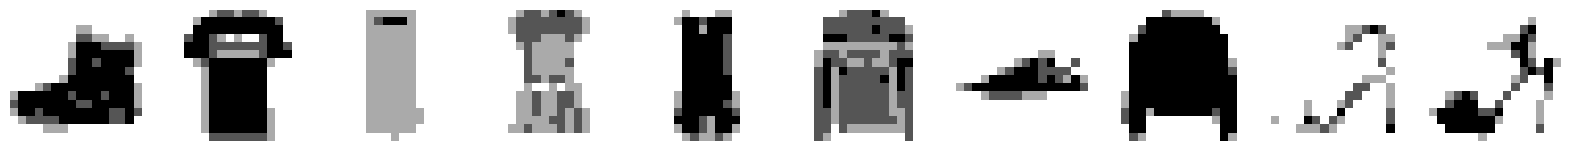

In [14]:
# Show some items of clothing from the training set
display(input_data)

## Building PixelCNN

In [15]:
# Input layer for grayscale images
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

# First masked convolution layer with mask type "A"
# which is typically used for the first layer in PixelCNN
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS,
    kernel_size=7,
    activation="relu",
    padding="same",
)(inputs)

# Apply a series of residual blocks
# These blocks allow for better gradient flow and deeper networks
for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)

# Apply two MaskedConv2D layers with mask type "B"
for _ in range(2):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1,
        strides=1,            # Stride of 1 to preserve the input size
        activation="relu",
        padding="valid",      # Valid padding = no padding
    )(x)

# Final convolution layer to output predictions
# This layer outputs a softmax over the PIXEL_LEVELS for each pixel
out = layers.Conv2D(
    filters=PIXEL_LEVELS,
    kernel_size=1,         # 1x1 convolution to reduce dimensionality to the number of pixel levels
    strides=1,
    activation="softmax",  # Softmax activation for classification
    padding="valid",
)(x)

# Create the PixelCNN model
pixel_cnn = models.Model(inputs, out)

# Print the model architecture summary
pixel_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 16, 16, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masked_conv2d (MaskedConv2D)         │ (None, 16, 16, 128)         │           6,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block (ResidualBlock)       │ (None, 16, 16, 128)         │          53,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_1 (ResidualBlock)     │ (None, 16, 16, 128)         │          53,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_2 (ResidualBlock)     │ (None, 16, 16, 128)         │          53,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_3 (ResidualBlock)     │ (None, 16, 16, 128)         │          53,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_4 (ResidualBlock)     │ (None, 16, 16, 128)         │          53,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masked_conv2d_6 (MaskedConv2D)       │ (None, 16, 16, 128)         │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masked_conv2d_7 (MaskedConv2D)       │ (None, 16, 16, 128)         │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 16, 16, 4)           │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 307,460 (1.17 MB)

 Trainable params: 307,460 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Setting up model optimizer and compiling model
adam = optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6353
Saved to /content/images/generated_img_000.png


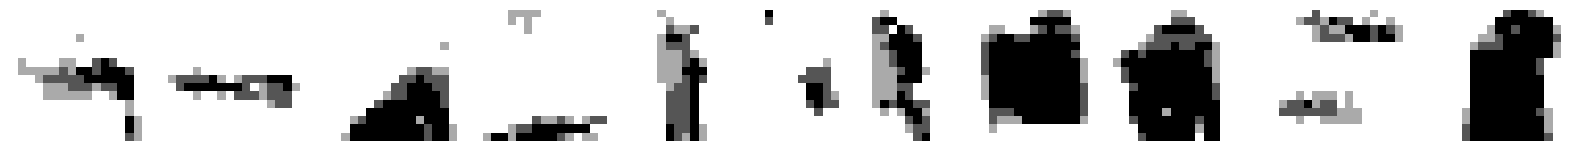

469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.6350
Epoch 2/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4014
Saved to /content/images/generated_img_001.png


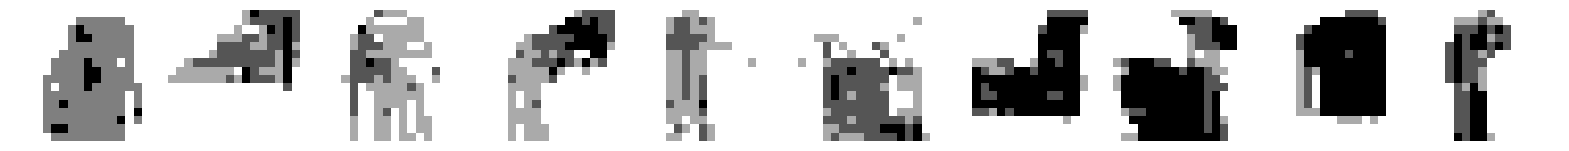

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.4013
Epoch 3/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3865
Saved to /content/images/generated_img_002.png


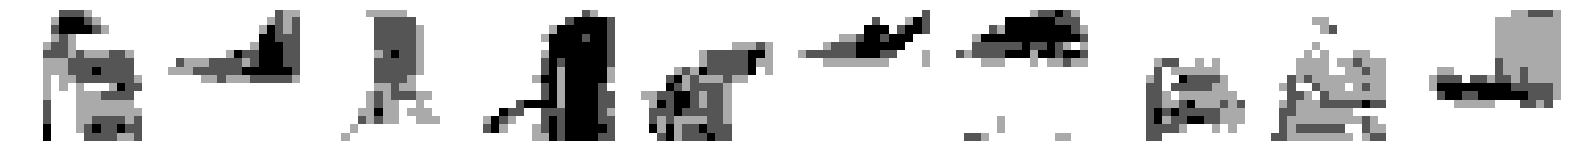

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3865
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3778
Saved to /content/images/generated_img_003.png


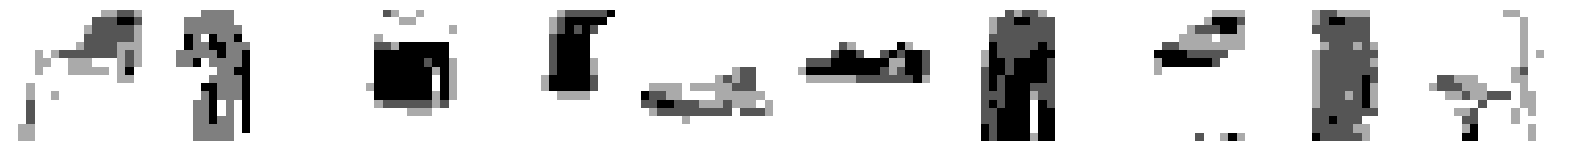

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3778
Epoch 5/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3738
Saved to /content/images/generated_img_004.png


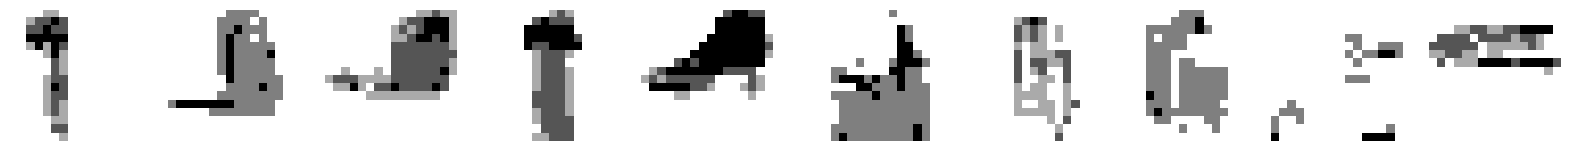

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.3738
Epoch 6/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3710
Saved to /content/images/generated_img_005.png


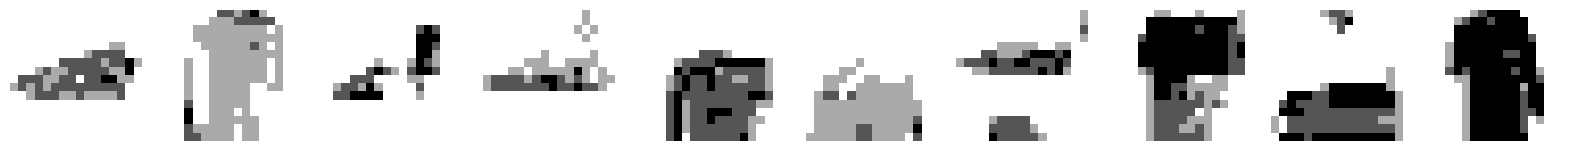

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3710
Epoch 7/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3690
Saved to /content/images/generated_img_006.png


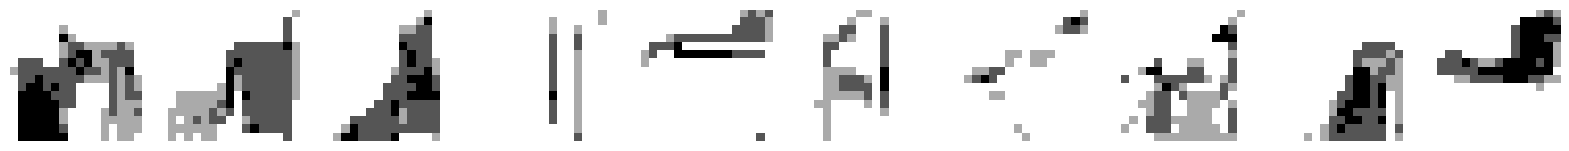

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.3690
Epoch 8/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3647
Saved to /content/images/generated_img_007.png


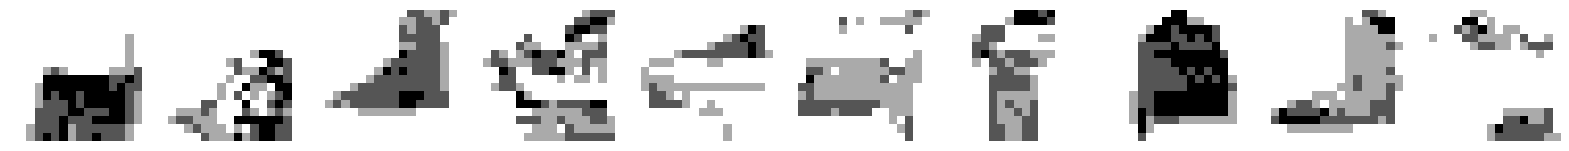

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3647
Epoch 9/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3623
Saved to /content/images/generated_img_008.png


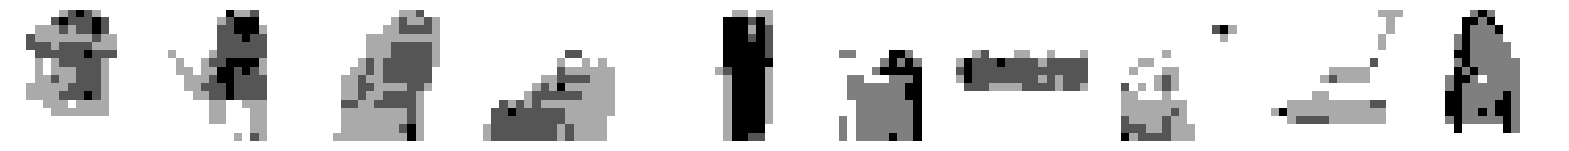

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3623
Epoch 10/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3607
Saved to /content/images/generated_img_009.png


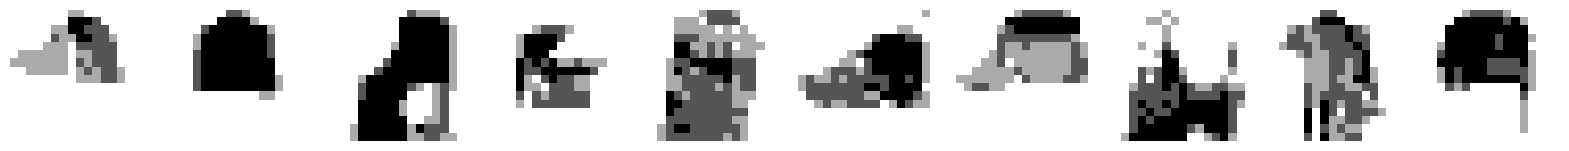

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.3607
Epoch 11/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3587
Saved to /content/images/generated_img_010.png


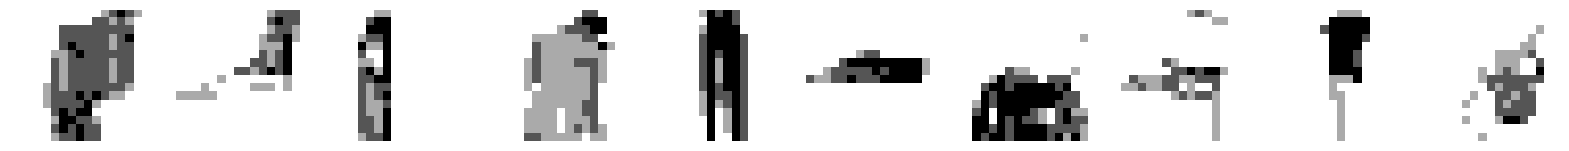

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3587
Epoch 12/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3573
Saved to /content/images/generated_img_011.png


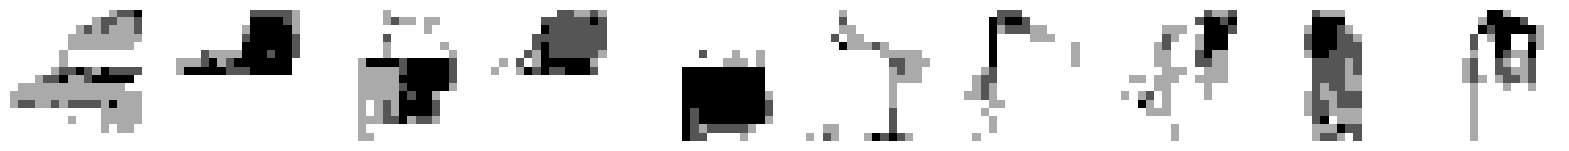

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3573
Epoch 13/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3560
Saved to /content/images/generated_img_012.png


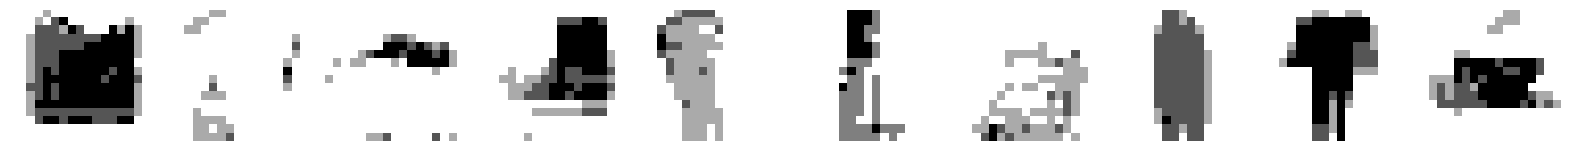

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3560
Epoch 14/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3543
Saved to /content/images/generated_img_013.png


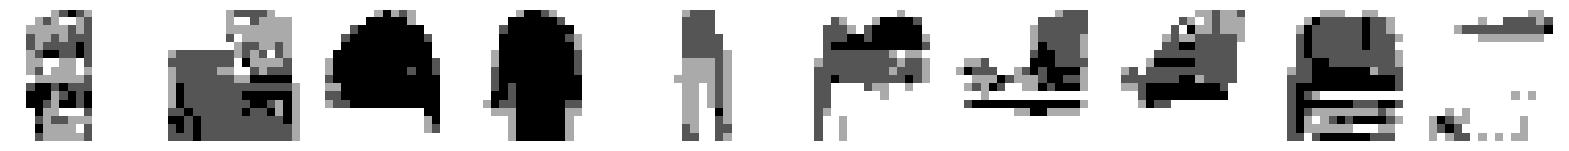

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3543
Epoch 15/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3530
Saved to /content/images/generated_img_014.png


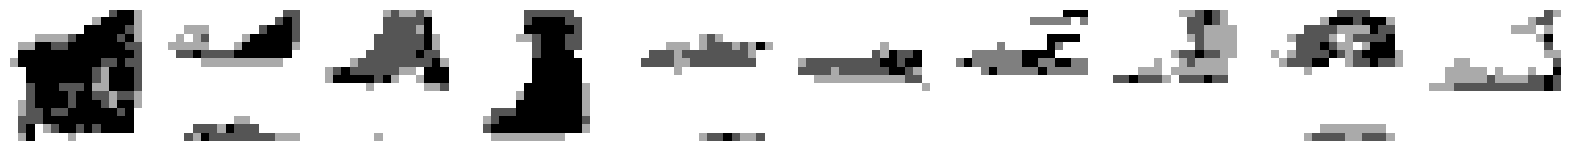

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3530
Epoch 16/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3520
Saved to /content/images/generated_img_015.png


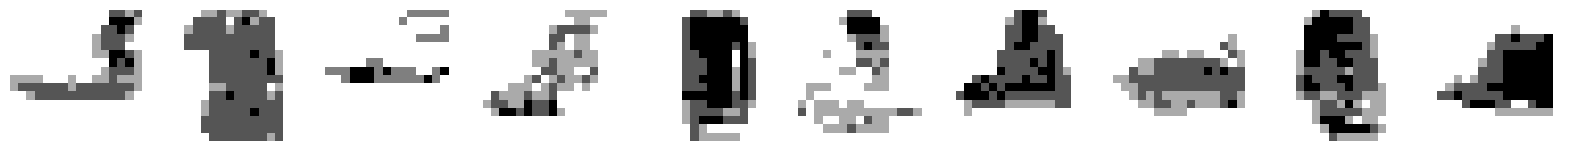

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3520
Epoch 17/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3513
Saved to /content/images/generated_img_016.png


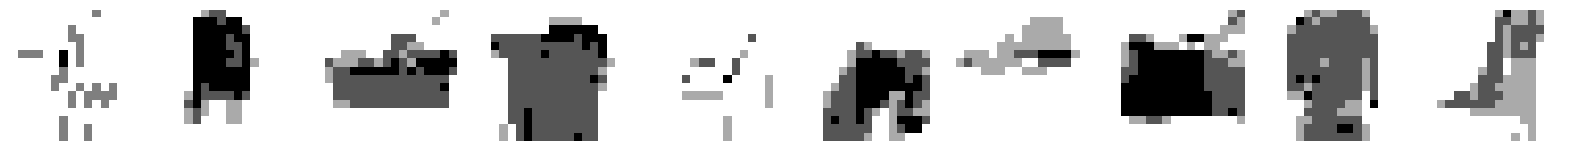

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3513
Epoch 18/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3502
Saved to /content/images/generated_img_017.png


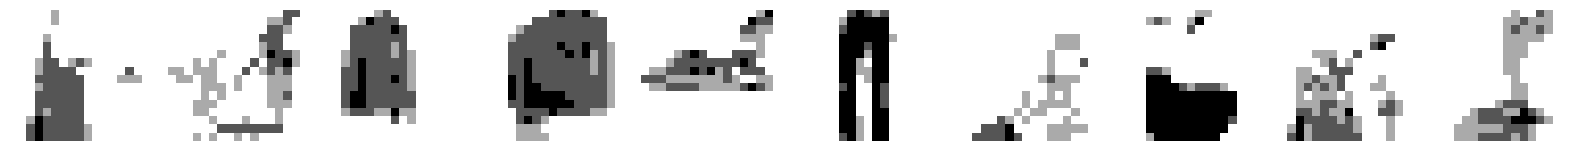

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3502
Epoch 19/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3482
Saved to /content/images/generated_img_018.png


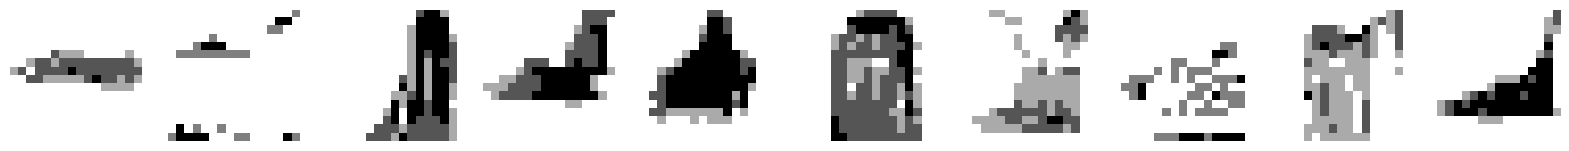

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.3482
Epoch 20/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3475
Saved to /content/images/generated_img_019.png


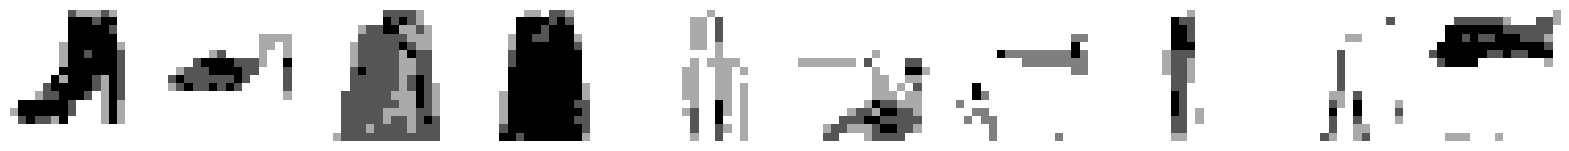

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3475
Epoch 21/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3478
Saved to /content/images/generated_img_020.png


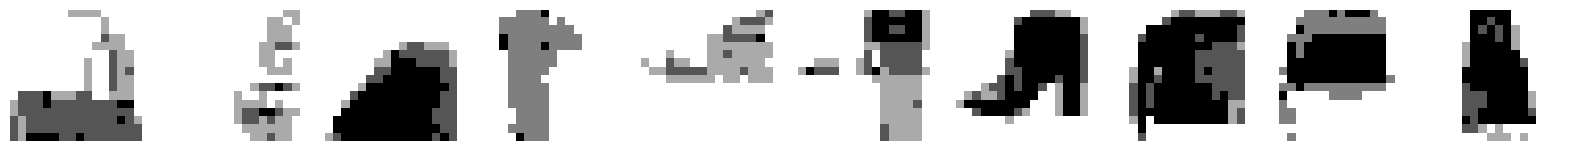

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.3478
Epoch 22/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3455
Saved to /content/images/generated_img_021.png


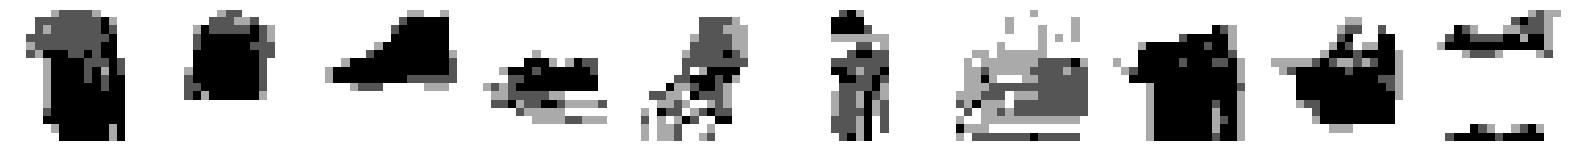

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3455
Epoch 23/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3453
Saved to /content/images/generated_img_022.png


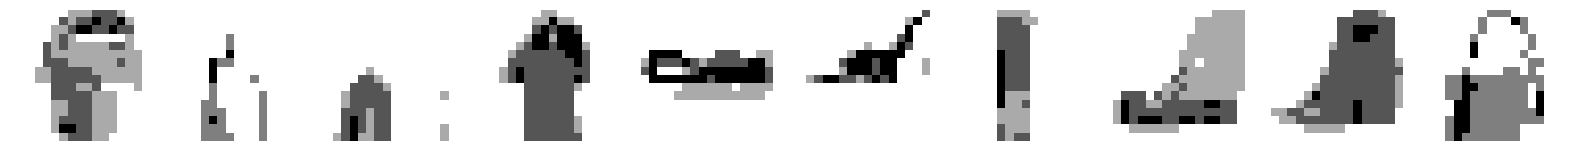

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.3453
Epoch 24/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3455
Saved to /content/images/generated_img_023.png


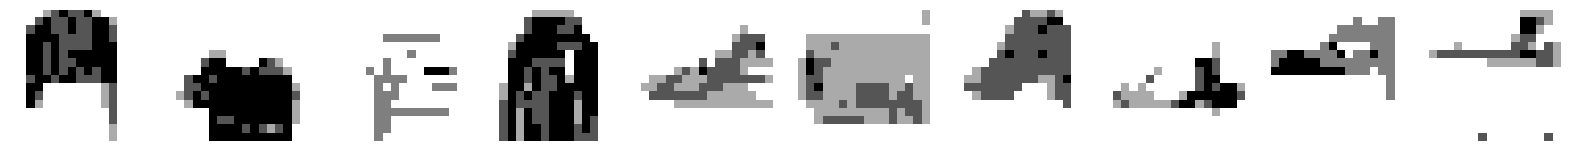

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3455
Epoch 25/25
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3445
Saved to /content/images/generated_img_024.png


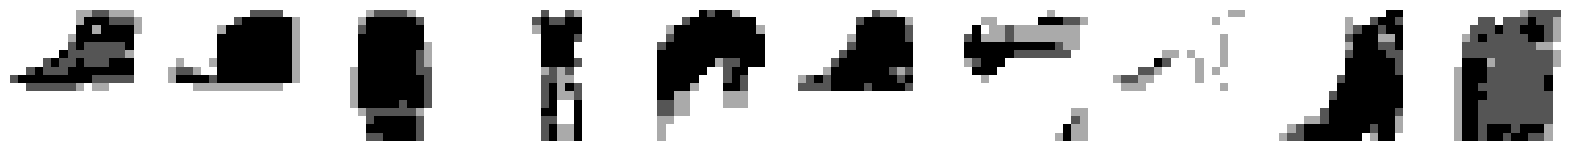

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.3445


In [17]:
# Fitting model
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback], # Custom callbacks
)